## Regridding SST for Coral Reefs use-case with BCDP

In [1]:
import os
import glob
import numpy as np
import bcdp
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
from get_poly import get_poly_bnd
warnings.filterwarnings("ignore")

These options are passed to the intake catalog to subselect which datasets we will download directly into memory from the cloud.

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/pangeo-cmip6.csv')
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
514813,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514814,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514815,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514816,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


In [3]:
# Dataset Options
variable_id = 'tos'
experiment_id = 'historical'
table_id = 'Omon'
member_id = 'r1i1p1f1'
grid_label = 'gn'
activity_id = 'CMIP'
source_id = ''

# Processing Options
backend = 'scipy'
method = 'linear'
res = (1.0, 1.0)
lat_bnds = (32, 43)
lon_bnds = (-130, -120)
time_bnds = ('1910-01-01', '1920-01-01')

In [4]:
query = dict(variable_id=variable_id, experiment_id=experiment_id, 
             table_id=table_id, member_id=member_id, grid_label=grid_label, 
             institution_id=institution_id, activity_id=activity_id)
zarr_kwargs = dict(consolidated=True)
ens = bcdp.load_intake_esm(query, zarr_kwargs=zarr_kwargs)
print(ens.size)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


3.89GB


In [5]:
bounds = bcdp.Bounds(lat_bnds=lat_bnds, lon_bnds=lon_bnds, time_bnds=time_bnds)
output_grid = bcdp.utils.grid_from_res(res, bounds)
ens_u = ens.homogenize(bounds=bounds, backend=backend, method=method,
                       output_grid=output_grid, clean=False, freq='A')

In [6]:
da = ens_u.bundle('SST').first
da

<xarray.DataArray 'SST' (names: 4, time: 165, y: 11, x: 10)>
dask.array<concatenate, shape=(4, 165, 11, 10), dtype=float32, chunksize=(1, 1, 11, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
    lat      (y, x) float64 dask.array<chunksize=(11, 10), meta=np.ndarray>
    lon      (y, x) float64 -141.8 -140.7 -139.6 -138.4 ... -133.9 -132.8 -131.7
  * x        (x) float64 -130.0 -129.0 -128.0 -127.0 ... -123.0 -122.0 -121.0
  * y        (y) float64 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0
  * names    (names) <U44 'CMIP.NCAR.CESM2-WACCM-FV2.historical.Omon.gn' ... ...
Attributes: (12/20)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        TEMP[:,0,:,:]
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos
    variable_name:  tos

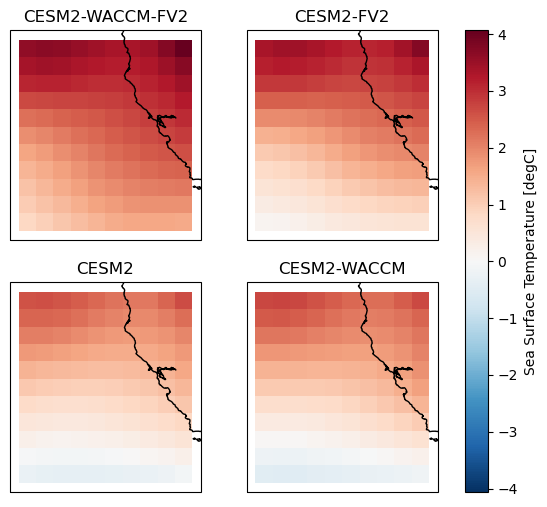

In [7]:
p = da.isel(time=0).plot(x='x', y='y', col='names', col_wrap=2,
                    subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
for name, ax in zip(da.names.values, p.axes.flat):
    ax.coastlines()
    ax.set_title(name.split('.')[2])

## Advanced Subsetting: High Resolution Precipitation for Tree Mortality Use-Case

In [8]:
# New settings for tree mortality case
variable_id = 'pr'
activity_id = 'HighResMIP'
table_id = 'Amon'
experiment_id = 'highresSST-present'

query = dict(variable_id=variable_id, experiment_id=experiment_id, 
             table_id=table_id, member_id=member_id, grid_label=grid_label, 
             activity_id=activity_id)
zarr_kwargs = dict(consolidated=True)
ens = bcdp.load_intake_esm(query, zarr_kwargs=zarr_kwargs)
print(ens.size)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


15.37GB


This time we derive the boundary from a GeoJSON file rather than a simple latlon bbox.

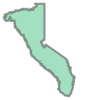

In [9]:
bounds = get_poly_bnd('Sierra_Nevada_Conservancy_Boundary_buffer.json', field='Id', time_bnds=(1950, 2014))
bounds.shapes

In [10]:
ens_u = ens.subset(bounds)

We will examine a single high resolution model in this set

In [11]:
da = ens_u['HighResMIP.MRI.MRI-AGCM3-2-S.highresSST-present.Amon.gn'].isel(time=0)
da

<xarray.DataArray 'HighResMIP.MRI.MRI-AGCM3-2-S.highresSST-present.Amon.gn' (y: 37, x: 29)>
dask.array<getitem, shape=(37, 29), dtype=float32, chunksize=(37, 29), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 35.14 35.33 35.51 35.7 35.89 ... 41.32 41.51 41.7 41.88
  * x        (x) float64 -123.0 -122.8 -122.6 -122.4 ... -118.1 -117.9 -117.8
    time     datetime64[ns] 1950-01-16T12:00:00
    lon      (y, x) float64 -123.0 -122.8 -122.6 -122.4 ... -118.1 -117.9 -117.8
    lat      (y, x) float64 35.14 35.14 35.14 35.14 ... 41.88 41.88 41.88 41.88
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    long_name:      Precipitation
    original_name:  PRECIPI
    standard_name:  precipitation_flux
    units:          kg m-2 s-1
    variable_name:  pr

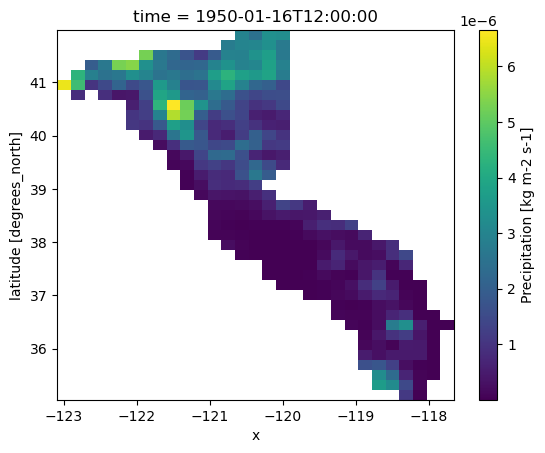

In [12]:
da.plot(x='x', y='y')